In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/moviedataset/tmdb_5000_credits.csv
/kaggle/input/movietitledataset/tmdb_5000_movies.csv


In [30]:
import pandas as pd
import ast
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display

In [6]:
movies = pd.read_csv("/kaggle/input/movietitledataset/tmdb_5000_movies.csv")
credits = pd.read_csv("/kaggle/input/moviedataset/tmdb_5000_credits.csv")


In [7]:
#merging datasets on movie ID
df = movies.merge(credits, left_on='id', right_on='movie_id')

In [8]:
#converting JSON Strings to Python Objects
json_cols = ['genres','keywords','production_companies','cast','crew']
for col in json_cols:
    df[col] = df[col].apply(ast.literal_eval)

In [9]:
#Extract Genre List
df['genres'] = df['genres'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])


In [10]:
#Extract Production Companies
df['companies'] = df['production_companies'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])

In [11]:
#Extract Director
def get_director(crew_list):
    for crew in crew_list:
        if crew['job'] == 'Director':
            return crew['name']
    return None
df['director'] = df['crew'].apply(get_director)

In [12]:
#Extract top 3 Cast
df['top_cast'] = df['cast'].apply(lambda x: [i['name'] for i in x[:3]] if isinstance(x, list) else [])

In [13]:
df['profit'] = df['revenue'] - df['budget']

# Explode the list of genres into separate rows
genre_profit = (
    df.explode('genres')                          # expand lists into rows
      .dropna(subset=['genres'])                  # drop NaNs
      .groupby('genres', as_index=False)['profit']# group by genre
      .mean()                                     # average profit per genre
      .sort_values('profit', ascending=False)     # sort highest first
)

print(genre_profit.head(10))  # top 10 genres by avg profit

             genres        profit
2         Animation  1.592271e+08
1         Adventure  1.423333e+08
8           Fantasy  1.297936e+08
7            Family  1.116260e+08
15  Science Fiction  1.005910e+08
0            Action  8.970235e+07
17         Thriller  4.907608e+07
18              War  4.887342e+07
13          Mystery  4.755644e+07
3            Comedy  4.597608e+07


In [14]:
genre_profit = (
    df.explode('genres')
      .dropna(subset=['genres'])
      .groupby('genres', as_index=False)['profit']
      .mean()
      .sort_values('profit', ascending=False)
)
print("Top 15 Genres by Average Profit")
display(genre_profit.head(15))

#Profit by Genre

Top 15 Genres by Average Profit


,genres,profit
2,Animation,1.592271e+08
1,Adventure,1.423333e+08
8,Fantasy,1.297936e+08
7,Family,1.116260e+08
15,Science Fiction,1.005910e+08
0,Action,8.970235e+07
17,Thriller,4.907608e+07
18,War,4.887342e+07
13,Mystery,4.755644e+07
3,Comedy,4.597608e+07


In [15]:
#Top Directors Avg Rating
director_rating = (
    df.dropna(subset=['director','vote_average'])
      .groupby('director')
      .agg(avg_rating=('vote_average','mean'), films=('id','count'))
      .query("films >= 3")
      .sort_values(['avg_rating','films'], ascending=[False, False])
      .reset_index()
)
print("\nTop 15 Directors by Avg Rating (min 3 films)")
display(director_rating.head(15))


Top 15 Directors by Avg Rating (min 3 films)


,director,avg_rating,films
0,Hayao Miyazaki,8.050000,4
1,Sergio Leone,8.000000,4
2,Christopher Nolan,7.800000,8
3,Quentin Tarantino,7.775000,8
4,Pete Docter,7.733333,3
5,Stanley Kubrick,7.683333,6
6,Denis Villeneuve,7.666667,3
7,Miloš Forman,7.633333,3
8,Frank Capra,7.620000,5
9,Billy Wilder,7.600000,4


In [16]:
# Most common actors overall & in blockbusters (top 10% revenue)
actor_counts = Counter([a for sub in df['top_cast'] for a in (sub if isinstance(sub, list) else [])])
top_actors_overall = pd.DataFrame(actor_counts.most_common(25), columns=['actor','count'])
print("\nTop 25 Actors (Top-billed frequency overall)")
display(top_actors_overall)

rev_thresh = df['revenue'].quantile(0.90)
blockbusters = df[df['revenue'] >= rev_thresh]
bb_actor_counts = Counter([a for sub in blockbusters['top_cast'] for a in (sub if isinstance(sub, list) else [])])
top_actors_blockbusters = pd.DataFrame(bb_actor_counts.most_common(25), columns=['actor','count'])
print("\nTop 25 Actors in Blockbusters (Top 10% revenue)")
display(top_actors_blockbusters)


Top 25 Actors (Top-billed frequency overall)


,actor,count
0,Robert De Niro,46
1,Samuel L. Jackson,35
2,Bruce Willis,35
3,Matt Damon,35
4,Nicolas Cage,34
5,Johnny Depp,32
6,Brad Pitt,30
7,Tom Hanks,29
8,Morgan Freeman,29
9,Denzel Washington,29



Top 25 Actors in Blockbusters (Top 10% revenue)


,actor,count
0,Tom Cruise,16
1,Will Smith,14
2,Tom Hanks,13
3,Johnny Depp,10
4,Ian McKellen,10
5,Brad Pitt,10
6,Cameron Diaz,10
7,Ben Stiller,10
8,Bruce Willis,10
9,Matt Damon,10


In [17]:
for col in ['budget', 'revenue', 'vote_average']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Parse release_date and derive year/decade
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year
df['decade'] = (df['release_year'] // 10) * 10

In [18]:
# Decade Trends: average budget, revenue, rating per decade
decade_trends = (
    df.dropna(subset=['decade'])
      .groupby('decade', as_index=False)[['budget','revenue','vote_average']]
      .mean()
      .sort_values('decade')
)

print("Decade Trends (Average Budget, Revenue, Rating)")
display(decade_trends)

Decade Trends (Average Budget, Revenue, Rating)


,decade,budget,revenue,vote_average
0,1910.0,3.859070e+05,8.394751e+06,7.400000
1,1920.0,2.331100e+07,6.752106e+06,6.900000
2,1930.0,1.342211e+06,4.475394e+07,6.920000
3,1940.0,1.837280e+06,2.371003e+07,6.900000
4,1950.0,2.664572e+06,1.422008e+07,7.092593
5,1960.0,4.990716e+06,3.138914e+07,6.942254
6,1970.0,7.008181e+06,6.003356e+07,6.774312
7,1980.0,1.297816e+07,6.101931e+07,6.371583
8,1990.0,2.866960e+07,7.879335e+07,6.237918
9,2000.0,3.047318e+07,7.646591e+07,6.070752


In [19]:
#Budget vs Correlation
corr_budget_revenue = df[['budget','revenue']].dropna().corr().loc['budget','revenue']
print(f"\nCorrelation (budget vs revenue): {corr_budget_revenue:.3f}")


Correlation (budget vs revenue): 0.731


In [20]:
#Top keywords overall & in blockbusters
all_keywords = Counter([kw.get('name') for row in df['keywords'] if isinstance(row, list) for kw in row])
top_keywords = pd.DataFrame(all_keywords.most_common(30), columns=['keyword','count'])
print("\nTop 30 Keywords (Overall)")
display(top_keywords)

bb_keywords = Counter([kw.get('name') for row in blockbusters['keywords'] if isinstance(row, list) for kw in row])
top_keywords_bb = pd.DataFrame(bb_keywords.most_common(30), columns=['keyword','count'])
print("\nTop 30 Keywords (Blockbusters: Top 10% revenue)")
display(top_keywords_bb)


Top 30 Keywords (Overall)


,keyword,count
0,woman director,324
1,independent film,318
2,duringcreditsstinger,307
3,based on novel,197
4,murder,189
5,aftercreditsstinger,170
6,violence,150
7,dystopia,139
8,sport,126
9,revenge,118



Top 30 Keywords (Blockbusters: Top 10% revenue)


,keyword,count
0,duringcreditsstinger,81
1,3d,52
2,aftercreditsstinger,46
3,based on novel,41
4,sequel,40
5,superhero,40
6,dystopia,39
7,based on comic book,32
8,marvel comic,28
9,violence,24


In [22]:
df['profit'] = df['revenue'] - df['budget']
genre_profit = (
    df.explode('genres')
      .dropna(subset=['genres'])
      .groupby('genres', as_index=False)['profit']
      .mean()
      .sort_values('profit', ascending=False)
)

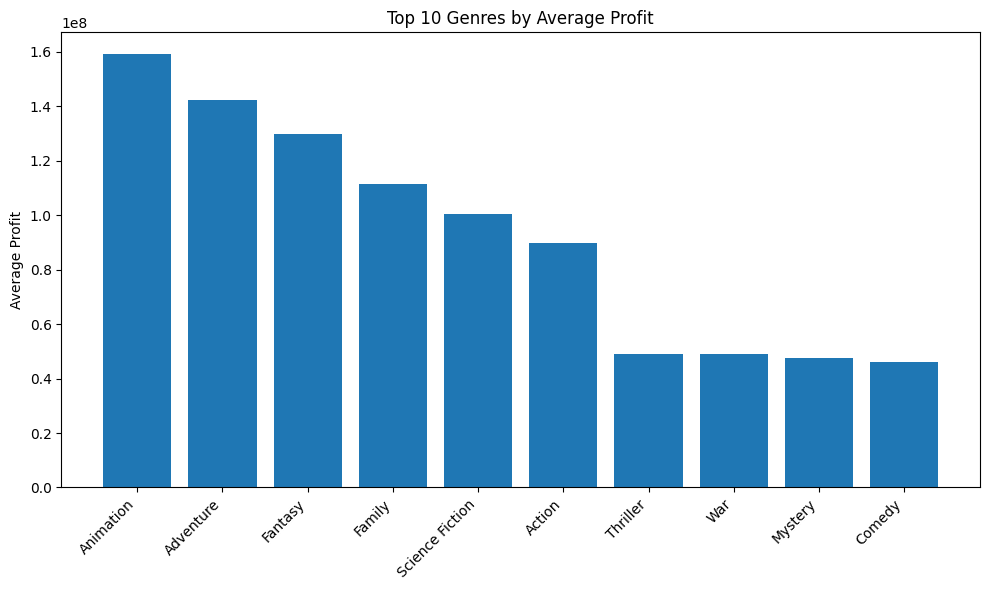

In [25]:
# Bar: Top 10 genres by avg profit
top10_genres = genre_profit.head(10)
plt.figure(figsize=(10,6))
plt.bar(top10_genres['genres'], top10_genres['profit'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Profit')
plt.title('Top 10 Genres by Average Profit')
plt.tight_layout()
plt.show()

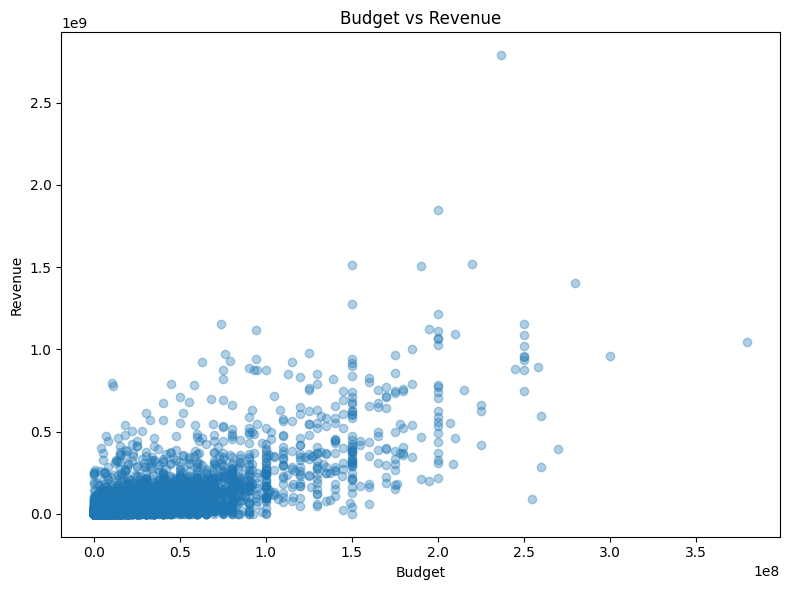

In [26]:
#  Scatter: Budget vs Revenue 
points = df[['budget','revenue']].dropna()
if len(points) > 5000:
    points = points.sample(5000, random_state=42)

plt.figure(figsize=(8,6))
plt.scatter(points['budget'], points['revenue'], alpha=0.35)
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Budget vs Revenue')
plt.tight_layout()
plt.show()

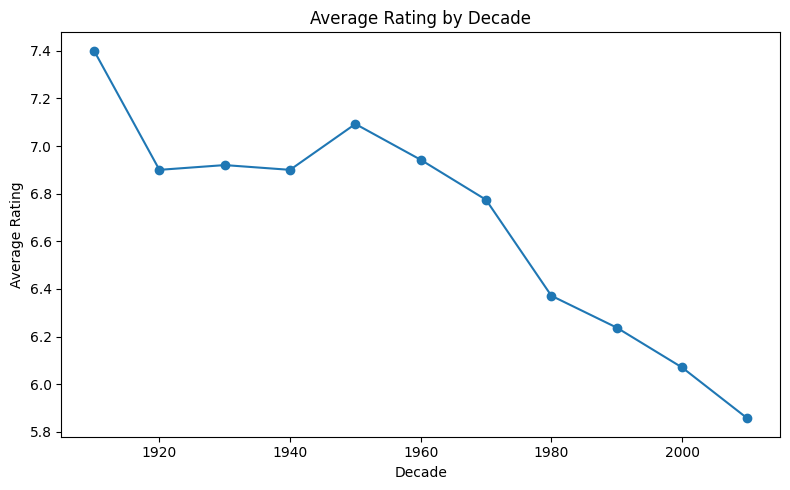

In [27]:
# Line: Average rating by decade
plt.figure(figsize=(8,5))
plt.plot(decade_trends['decade'], decade_trends['vote_average'], marker='o')
plt.xlabel('Decade')
plt.ylabel('Average Rating')
plt.title('Average Rating by Decade')
plt.tight_layout()
plt.show()

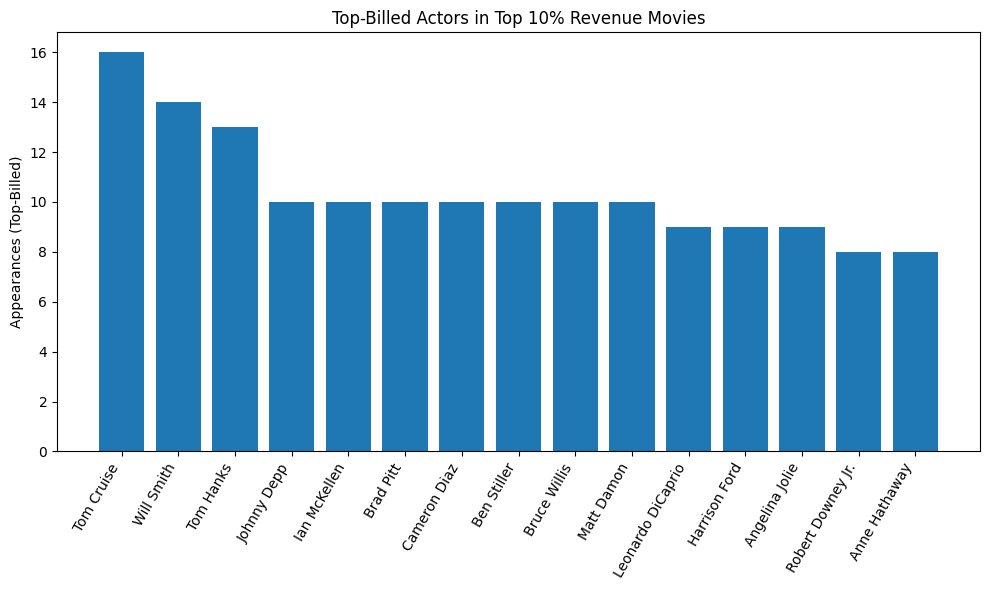

In [28]:
#  Bar: Top 15 actors in blockbusters
top15_bb_actors = top_actors_blockbusters.head(15)
plt.figure(figsize=(10,6))
plt.bar(top15_bb_actors['actor'], top15_bb_actors['count'])
plt.xticks(rotation=60, ha='right')
plt.ylabel('Appearances (Top-Billed)')
plt.title('Top-Billed Actors in Top 10% Revenue Movies')
plt.tight_layout()
plt.show()

In [31]:
g1 = genre_profit.iloc[0] if not genre_profit.empty else None
d1 = director_rating.iloc[0] if not director_rating.empty else None
a1 = top_actors_overall.iloc[0] if not top_actors_overall.empty else None
a1_bb = top_actors_blockbusters.iloc[0] if not top_actors_blockbusters.empty else None

insights = []

if g1 is not None:
    insights.append(f"Highest average profit genre: {g1['genres']} (≈ ${g1['profit']:,.0f}).")

insights.append(f"Correlation between budget and revenue: {corr_budget_revenue:.2f} "
                f"({'positive' if corr_budget_revenue>0 else 'negative' if corr_budget_revenue<0 else 'no'}) relationship.")

if d1 is not None:
    insights.append(f"Top-rated director (min 3 films): {d1['director']} with avg rating {d1['avg_rating']:.2f} across {int(d1['films'])} films.")

if a1 is not None:
    insights.append(f"Most frequent top-billed actor overall: {a1['actor']} ({int(a1['count'])} films).")

if a1_bb is not None:
    insights.append(f"Most frequent top-billed actor in blockbusters: {a1_bb['actor']} ({int(a1_bb['count'])} films).")

if not decade_trends.empty:
    best_decade = decade_trends.sort_values('vote_average', ascending=False).iloc[0]
    insights.append(f"Highest average ratings by decade: {int(best_decade['decade'])}s "
                    f"(avg rating {best_decade['vote_average']:.2f}).")

print("\n=== Key Insights ===")
for i, line in enumerate(insights, 1):
    print(f"{i}. {line}")


=== Key Insights ===
1. Highest average profit genre: Animation (≈ $159,227,123).
2. Correlation between budget and revenue: 0.73 (positive) relationship.
3. Top-rated director (min 3 films): Hayao Miyazaki with avg rating 8.05 across 4 films.
4. Most frequent top-billed actor overall: Robert De Niro (46 films).
5. Most frequent top-billed actor in blockbusters: Tom Cruise (16 films).
6. Highest average ratings by decade: 1910s (avg rating 7.40).


In [32]:
summary_rows = {
    'corr_budget_revenue': [corr_budget_revenue],
    'top_genre_by_profit': [g1['genres'] if g1 is not None else None],
    'top_genre_avg_profit': [g1['profit'] if g1 is not None else None],
    'top_director_by_rating': [d1['director'] if d1 is not None else None],
    'top_director_avg_rating': [d1['avg_rating'] if d1 is not None else None],
    'top_actor_overall': [a1['actor'] if a1 is not None else None],
    'top_actor_overall_count': [a1['count'] if a1 is not None else None],
    'top_actor_blockbusters': [a1_bb['actor'] if a1_bb is not None else None],
    'top_actor_blockbusters_count': [a1_bb['count'] if a1_bb is not None else None],
}
kpis = pd.DataFrame(summary_rows)
print("Summary KPIs")
display(kpis)


Summary KPIs


,corr_budget_revenue,top_genre_by_profit,top_genre_avg_profit,top_director_by_rating,top_director_avg_rating,top_actor_overall,top_actor_overall_count,top_actor_blockbusters,top_actor_blockbusters_count
0,0.730823,Animation,1.592271e+08,Hayao Miyazaki,8.05,Robert De Niro,46,Tom Cruise,16
